# 一，准备数据

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [13]:
# 两种方法
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils

from keras.datasets import mnist
# Sequential按顺序构成的模型
from keras.models import Sequential
# Dense全连接层
from keras.layers import Dense,Activation,Dropout,Convolution2D,MaxPool2D,Flatten

# RNN的模型
from keras.layers import SimpleRNN,LSTM,GRU
# 优化器
from keras.optimizers import SGD,Adam


In [14]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

# import tensorflow as tf 
# from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

Survived:0代表死亡，1代表存活【y标签】

Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】

Name:乘客姓名 【舍去】

Sex:乘客性别 【转换成bool特征】

Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】

SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】

Parch:乘客父母/孩子的个数(整数值)【数值特征】

Ticket:票号(字符串)【舍去】

Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】

Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】

Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。



label分布情况

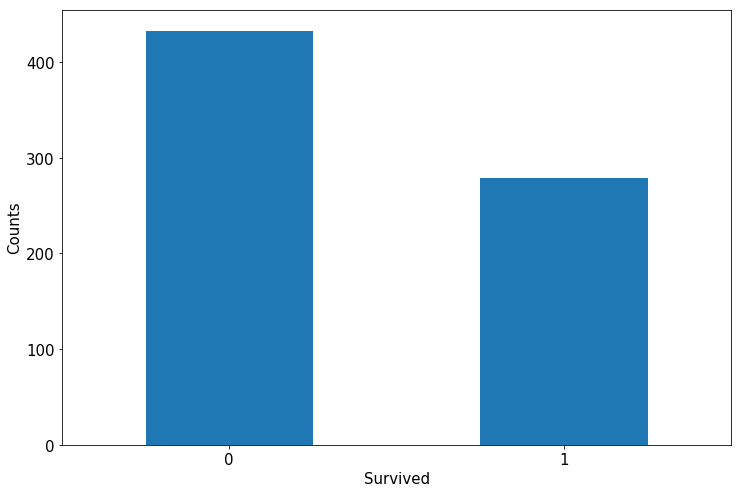

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

年龄分布情况

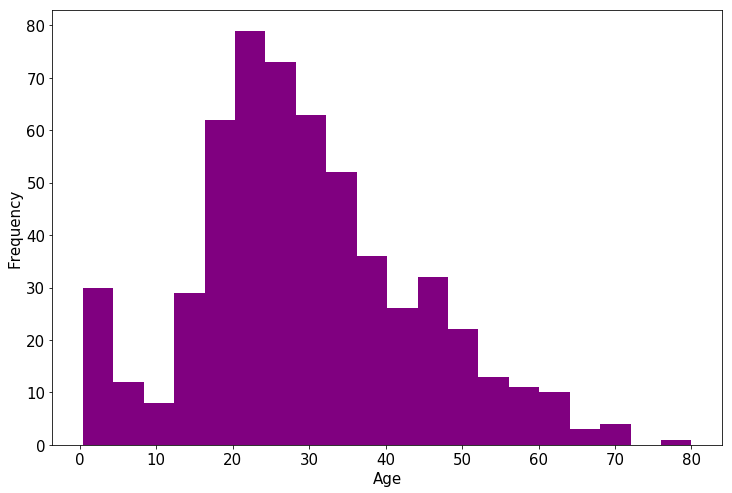

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

年龄和label的相关性

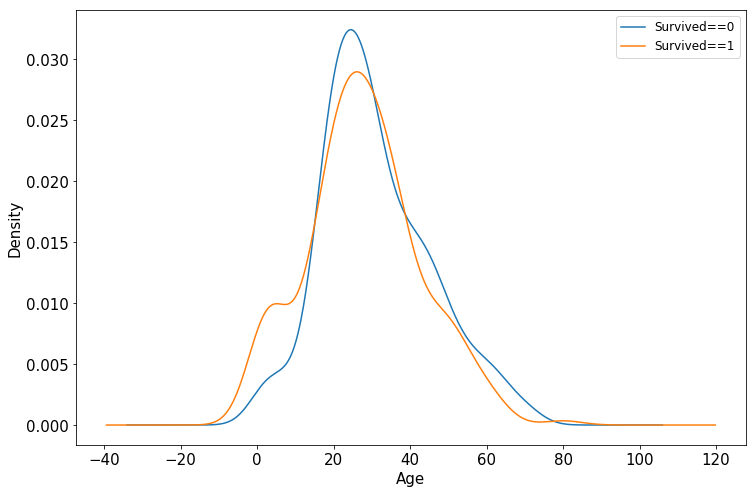

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

下面为正式的数据预处理

In [18]:
import pandas as pd
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isnull(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isnull(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


In [19]:
y_train.shape

(712,)

In [20]:
y_test.shape

(179,)

In [21]:

# 载入数据
# (x_train,y_train),(x_test,y_test)=mnist.load_data()

print('xtrain',x_train.shape)
print('ytrain',y_train.shape)

# -1是自动转换，255.0是为了归一化
# (60000, 28, 28)->(60000, 28,28,1)转化形式
train_value=x_train.values.reshape(712,15)

test_value=x_test.values.reshape(179,15)

print('trainvalue',train_value.shape)
print('testvalue',test_value.shape)

import numpy as np
a=train_value
train=np.reshape(a,(-1,15,1))
b=test_value
test=np.reshape(b,(-1,15,1))

print('xtrain',train.shape)
print('xtest',test.shape)



xtrain (712, 15)
ytrain (712,)
trainvalue (712, 15)
testvalue (179, 15)
xtrain (712, 15, 1)
xtest (179, 15, 1)


In [22]:
#序列长度 一共28行
time_steps=15
# 数据长度 一行28个元素
input_size=1
#隐藏层 size 50
cell_size=50

#parameters for LSTM
nb_lstm_outputs = 50  #神经元个数
nb_time_steps = 15  #时间序列长度
nb_input_vector = 1 #输入序列

# 转化成one-hot格式
y_train=np_utils.to_categorical(y_train,num_classes=2)
y_test=np_utils.to_categorical(y_test,num_classes=2)

# # 创建模型,输入784个神经元，输出10个神经元
# model=Sequential(
# # [Dense(units=10,input_dim=784,bias_initializer='one',activation='softmax')]
# )
# # 第一个卷积层

 
# model.add(
# SimpleRNN(
# units=cell_size , # 输出
# input_shape=(time_steps,input_size)    # 输入
# ))

# model.add(
# Dense(2,activation='softmax')
# )

 #build model
model = Sequential()
model.add(LSTM(units=nb_lstm_outputs, input_shape=(nb_time_steps, nb_input_vector)))
model.add(Dense(2, activation='softmax'))

# 分类模型使用交叉熵速度比较快
# sgd=SGD(lr=0.3)
adam=Adam(lr=1e-4)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

# 训练
# batch_size=32一次训练32章，epochs 训练10轮，把所有的图片都训练一次
model.fit(train,y_train,batch_size=100,epochs=10)
#评估模型
loss,accuray=model.evaluate(test,y_test)

print('\test loss',loss)
print('accuray',accuray)




Epoch 1/10
712/712 [==============================] - 1s 740us/step - loss: 0.6741 - accuracy: 0.6081
Epoch 2/10
712/712 [==============================] - 0s 166us/step - loss: 0.6717 - accuracy: 0.6081
Epoch 3/10
712/712 [==============================] - 0s 170us/step - loss: 0.6695 - accuracy: 0.60810s - loss: 0.6769 - accuracy: 0.59
Epoch 4/10
712/712 [==============================] - 0s 174us/step - loss: 0.6681 - accuracy: 0.6081
Epoch 5/10
712/712 [==============================] - 0s 157us/step - loss: 0.6667 - accuracy: 0.6081
Epoch 6/10
712/712 [==============================] - 0s 160us/step - loss: 0.6651 - accuracy: 0.6081
Epoch 7/10
712/712 [==============================] - 0s 159us/step - loss: 0.6635 - accuracy: 0.6081
Epoch 8/10
712/712 [==============================] - 0s 154us/step - loss: 0.6623 - accuracy: 0.6081
Epoch 9/10
712/712 [==============================] - 0s 159us/step - loss: 0.6611 - accuracy: 0.6081
Epoch 10/10
179/179 [===========================